# RoCE Link Aggregation: Bonding vs NIXL

This notebook compares two approaches to using dual 100G RoCE links on DGX Spark:

| Approach | Traffic Type | Expected Throughput | Latency |
|----------|--------------|---------------------|----------|
| Linux Bonding | TCP/IP | ~60-70 Gbps | 50-200 μs |
| NIXL | Point-to-point RDMA | ~176 Gbps | 1-2 μs |

**Goal**: Demonstrate why NIXL outperforms bonding for point-to-point inference data movement.

For collective operations (all-reduce, all-gather), see the [first tutorial](01_InfiniBand_Tutorial.ipynb) which covers NCCL.

**Prerequisites**:
- Two DGX Spark systems connected via both RoCE ports
- IP addresses configured on RoCE interfaces
- `perftest` and `iperf3` installed

## Setup and Configuration

In [14]:
import subprocess
import re
import time
import os

# Configuration - Update these for your environment
LOCAL_IP = "192.168.100.11"    # This node's RoCE IP
REMOTE_IP = "192.168.100.10"   # Remote node's RoCE IP
INTERFACE_1 = "enp1s0f0np0"    # First RoCE interface
INTERFACE_2 = "enp1s0f1np1"    # Second RoCE interface

def run_cmd(cmd, timeout=60):
    """Run a shell command and return output."""
    try:
        result = subprocess.run(
            cmd, shell=True, capture_output=True, text=True, timeout=timeout
        )
        return result.stdout + result.stderr
    except subprocess.TimeoutExpired:
        return "Command timed out"

def parse_bandwidth(output, pattern):
    """Extract bandwidth value from command output."""
    match = re.search(pattern, output)
    return float(match.group(1)) if match else None

print("Configuration loaded")
print(f"Local IP: {LOCAL_IP}")
print(f"Remote IP: {REMOTE_IP}")

Configuration loaded
Local IP: 192.168.100.11
Remote IP: 192.168.100.10


## Part 1: Verify Network Interfaces

Check that both RoCE interfaces are available and operational.

In [2]:
# Check interface status
print("=== Network Interfaces ===")
print(run_cmd(f"ip link show {INTERFACE_1}"))
print(run_cmd(f"ip link show {INTERFACE_2}"))

=== Network Interfaces ===
3: enp1s0f0np0: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc mq state UP mode DEFAULT group default qlen 1000
    link/ether 30:c5:99:3e:6a:13 brd ff:ff:ff:ff:ff:ff

4: enp1s0f1np1: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 9000 qdisc mq state UP mode DEFAULT group default qlen 1000
    link/ether 30:c5:99:3e:6a:14 brd ff:ff:ff:ff:ff:ff



In [3]:
# Check RDMA devices
print("=== RDMA Devices ===")
print(run_cmd("ibv_devinfo"))

=== RDMA Devices ===
hca_id:	rocep1s0f0
	transport:			InfiniBand (0)
	fw_ver:				28.45.4028
	node_guid:			30c5:9903:003e:6a13
	sys_image_guid:			30c5:9903:003e:6a13
	vendor_id:			0x02c9
	vendor_part_id:			4129
	hw_ver:				0x0
	board_id:			NVD0000000087
	phys_port_cnt:			1
		port:	1
			state:			PORT_ACTIVE (4)
			max_mtu:		4096 (5)
			active_mtu:		4096 (5)
			sm_lid:			0
			port_lid:		0
			port_lmc:		0x00
			link_layer:		Ethernet

hca_id:	rocep1s0f1
	transport:			InfiniBand (0)
	fw_ver:				28.45.4028
	node_guid:			30c5:9903:003e:6a14
	sys_image_guid:			30c5:9903:003e:6a13
	vendor_id:			0x02c9
	vendor_part_id:			4129
	hw_ver:				0x0
	board_id:			NVD0000000087
	phys_port_cnt:			1
		port:	1
			state:			PORT_ACTIVE (4)
			max_mtu:		4096 (5)
			active_mtu:		4096 (5)
			sm_lid:			0
			port_lid:		0
			port_lmc:		0x00
			link_layer:		Ethernet

hca_id:	roceP2p1s0f0
	transport:			InfiniBand (0)
	fw_ver:				28.45.4028
	node_guid:			30c5:9903:003e:6a17
	sys_image_guid:			30c5:9903:003e:6a13
	vendor

In [10]:
# Verify connectivity to remote node
print("=== Connectivity Test ===")
print(run_cmd(f"ping -c 3 {REMOTE_IP}"))

=== Connectivity Test ===
PING 192.168.100.10 (192.168.100.10) 56(84) bytes of data.
From 192.168.100.11 icmp_seq=1 Destination Host Unreachable
From 192.168.100.11 icmp_seq=2 Destination Host Unreachable
From 192.168.100.11 icmp_seq=3 Destination Host Unreachable

--- 192.168.100.10 ping statistics ---
3 packets transmitted, 0 received, +3 errors, 100% packet loss, time 2059ms
pipe 3



---

## Part 2: Baseline RDMA Performance (Single Link)

Measure raw RDMA bandwidth on a single 100G link using `ib_write_bw`.

### RoCE GID Index Selection

RoCE requires specifying the correct GID (Global Identifier) index. GID index 0 is typically link-local (`fe80::`) and does not work for routed connections.

Check available GIDs:
```bash
show_gids
```

For RoCEv2 with IPv4, use index 3 (the entry showing your IPv4 address with `v2`):
| Index | Type | Use |
|-------|------|-----|
| 0-1 | fe80:: (link-local) | Does not work for RoCE |
| 2 | IPv4-mapped, RoCEv1 | Legacy, may not work |
| 3 | IPv4-mapped, RoCEv2 | **Use this** |

**Run on remote node first:**
```bash
ib_write_bw -d rocep1s0f0 -x 3
```

In [5]:
# Single-link RDMA bandwidth test
# Requires server running on remote: ib_write_bw -d rocep1s0f0 -x 3

# GID index 3 = RoCEv2 with IPv4 address (required for RoCE connections)
GID_INDEX = 3

print("=== RDMA Bandwidth (Single Link - rocep1s0f0) ===")
print(f"NOTE: Start server on remote node: ib_write_bw -d rocep1s0f0 -x {GID_INDEX}")
print()

output = run_cmd(f"ib_write_bw -d rocep1s0f0 -x {GID_INDEX} {REMOTE_IP}")
print(output)

# Parse result
bw = parse_bandwidth(output, r"(\d+\.?\d*)\s+MB/sec")
if bw:
    print(f"\n>>> Single Link RDMA: {bw:.0f} MB/s ({bw * 8 / 1000:.1f} Gbps)")

=== RDMA Bandwidth (Single Link - rocep1s0f0) ===
NOTE: Start server on remote node: ib_write_bw -d rocep1s0f0 -x 3

---------------------------------------------------------------------------------------
                    RDMA_Write BW Test
 Dual-port       : OFF		Device         : rocep1s0f0
 Number of qps   : 1		Transport type : IB
 Connection type : RC		Using SRQ      : OFF
 PCIe relax order: ON
 ibv_wr* API     : ON
 TX depth        : 128
 CQ Moderation   : 1
 Mtu             : 4096[B]
 Link type       : Ethernet
 GID index       : 3
 Max inline data : 0[B]
 rdma_cm QPs	 : OFF
 Data ex. method : Ethernet
---------------------------------------------------------------------------------------
 local address: LID 0000 QPN 0x02e4 PSN 0x58e43e RKey 0x182f00 VAddr 0x00e58409ead000
 GID: 00:00:00:00:00:00:00:00:00:00:255:255:192:168:100:11
 remote address: LID 0000 QPN 0x02ad PSN 0x83aed RKey 0x183700 VAddr 0x00fa5cbf676000
 GID: 00:00:00:00:00:00:00:00:00:00:255:255:192:168:100:10
----

---

## Part 3: Linux Bonding Performance (TCP/IP)

Bonding aggregates TCP traffic but **does not work with RDMA**.

### Critical Limitation: RDMA and Bonding Are Mutually Exclusive

When interfaces are enslaved to a bond:
- **TCP/IP works** through the bond interface (kernel stack)
- **RDMA fails** because verbs bypass the kernel and cannot traverse bond0

The `show_gids` output shows this: when bonded, GID entries associate with `bond0` instead of the physical interface, breaking RDMA connectivity.

**Testing sequence for this tutorial:**
1. Test RDMA first (Part 2) with unbonded interfaces
2. Create bond and test TCP (Part 3)
3. Remove bond before testing NIXL (Part 4)

### Bond Mode Selection

Linux bonding supports several modes. For direct-connect (no switch), only modes 0 and 2 are practical:

| Mode | Name | Hash Basis | Best For |
|------|------|------------|----------|
| 0 | balance-rr | Per-packet round-robin | Maximum single-flow throughput (causes reordering) |
| 1 | active-backup | None (failover only) | High availability, not performance |
| 2 | balance-xor | IP + port hash | Multiple flows, preserves packet order |
| 4 | 802.3ad | LACP negotiation | Requires switch support |

**Why balance-xor (mode 2) for this tutorial:**
- Each TCP connection hashes to one interface consistently
- No out-of-order packets (unlike balance-rr)
- Multiple parallel streams distribute across both links
- Single streams limited to one link (~35 Gbps) but without reordering overhead

**Trade-off:** balance-rr can achieve higher single-stream throughput by spreading packets across links, but causes TCP reordering which triggers congestion control. balance-xor sacrifices single-stream aggregation for predictable behavior.

### 3.0 Configure Jumbo Frames (MTU 9000)

RoCE links require jumbo frames for optimal TCP performance. The default MTU of 1500 bytes causes excessive packet fragmentation and triggers TCP congestion control, resulting in near-zero throughput.

**Symptoms of MTU mismatch:**
- Cwnd (congestion window) stuck at ~1.4 KB
- High retransmit counts
- Near-zero throughput despite successful connection

**Set MTU on both nodes:**
```bash
# On spark-01 (192.168.100.10)
sudo ip link set enp1s0f0np0 mtu 9000
sudo ip link set enp1s0f1np1 mtu 9000

# On spark-02 (192.168.100.11)
sudo ip link set enp1s0f0np0 mtu 9000
sudo ip link set enp1s0f1np1 mtu 9000
sudo ip link set bond0 mtu 9000  # Only if bond exists
```

**Verify on both nodes:**
```bash
cat /sys/class/net/enp1s0f0np0/mtu  # Should show 9000
cat /sys/class/net/enp1s0f1np1/mtu  # Should show 9000
```

Both endpoints must have matching MTU. A mismatch causes fragmentation and triggers TCP congestion control.

In [14]:
# Check if bond already exists on this node
bond_status = run_cmd("cat /proc/net/bonding/bond0 2>/dev/null")

if "Bonding Mode" in bond_status:
    print("Bond interface exists on THIS NODE (spark-02):")
    print(bond_status)
    print()
    print("=" * 70)
    print("⚠️  IMPORTANT: Also verify bond on spark-01 (192.168.100.10)")
    print("=" * 70)
else:
    print("No bond interface found on THIS NODE.")

print()
print("=" * 70)
print("Bond setup commands for BOTH nodes:")
print("=" * 70)
print()
print("--- ON SPARK-01 (192.168.100.10): ---")
print(f"""
sudo modprobe bonding
sudo ip link add bond0 type bond mode balance-xor
sudo ip link set bond0 type bond miimon 100
sudo ip link set bond0 type bond xmit_hash_policy layer3+4

sudo ip link set {INTERFACE_1} down
sudo ip link set {INTERFACE_1} master bond0
sudo ip link set {INTERFACE_1} up

sudo ip link set {INTERFACE_2} down
sudo ip link set {INTERFACE_2} master bond0
sudo ip link set {INTERFACE_2} up

sudo ip addr add 192.168.100.10/24 dev bond0
sudo ip link set bond0 up
""")
print("--- ON SPARK-02 (192.168.100.11) - THIS NODE: ---")
print(f"""
sudo modprobe bonding
sudo ip link add bond0 type bond mode balance-xor
sudo ip link set bond0 type bond miimon 100
sudo ip link set bond0 type bond xmit_hash_policy layer3+4

sudo ip link set {INTERFACE_1} down
sudo ip link set {INTERFACE_1} master bond0
sudo ip link set {INTERFACE_1} up

sudo ip link set {INTERFACE_2} down
sudo ip link set {INTERFACE_2} master bond0
sudo ip link set {INTERFACE_2} up

sudo ip addr add {LOCAL_IP}/24 dev bond0
sudo ip link set bond0 up
""")

Bond interface exists on THIS NODE (spark-02):
Ethernet Channel Bonding Driver: v6.14.0-1015-nvidia

Bonding Mode: load balancing (xor)
Transmit Hash Policy: layer3+4 (1)
MII Status: up
MII Polling Interval (ms): 100
Up Delay (ms): 0
Down Delay (ms): 0
Peer Notification Delay (ms): 0

Slave Interface: enp1s0f0np0
MII Status: up
Speed: 100000 Mbps
Duplex: full
Link Failure Count: 0
Permanent HW addr: 30:c5:99:3e:6a:13
Slave queue ID: 0

Slave Interface: enp1s0f1np1
MII Status: up
Speed: 100000 Mbps
Duplex: full
Link Failure Count: 0
Permanent HW addr: 30:c5:99:3e:6a:14
Slave queue ID: 0


⚠️  IMPORTANT: Also verify bond on spark-01 (192.168.100.10)

Bond setup commands for BOTH nodes:

--- ON SPARK-01 (192.168.100.10): ---

sudo modprobe bonding
sudo ip link add bond0 type bond mode balance-xor
sudo ip link set bond0 type bond miimon 100
sudo ip link set bond0 type bond xmit_hash_policy layer3+4

sudo ip link set enp1s0f0np0 down
sudo ip link set enp1s0f0np0 master bond0
sudo ip link se

### 3.2 Test Bonded TCP Performance

**Before running iperf3, verify connectivity:**
- Ensure bond0 is up on spark-01 with IP 192.168.100.10
- Check: `ip addr show bond0` on spark-01
- Verify ping works from current node to 192.168.100.10

**Run on remote node (spark-01):**
```bash
iperf3 -s -B 192.168.100.10
```

In [15]:
# iperf3 single stream over bond
print("=== TCP Bandwidth (Single Stream) ===")
print("NOTE: Start server on remote: iperf3 -s -B", REMOTE_IP)
print()

output = run_cmd(f"iperf3 -c {REMOTE_IP} -t 10")
print(output)

# Parse sender bandwidth
bw = parse_bandwidth(output, r"sender\s+.*?(\d+\.?\d*)\s+Gbits/sec")
if bw:
    print(f"\n>>> TCP Single Stream: {bw:.1f} Gbps")

=== TCP Bandwidth (Single Stream) ===
NOTE: Start server on remote: iperf3 -s -B 192.168.100.10

Connecting to host 192.168.100.10, port 5201
[  5] local 192.168.100.11 port 58550 connected to 192.168.100.10 port 5201
[ ID] Interval           Transfer     Bitrate         Retr  Cwnd
[  5]   0.00-1.00   sec  4.82 GBytes  41.3 Gbits/sec  1652    819 KBytes       
[  5]   1.00-2.00   sec  3.08 GBytes  26.5 Gbits/sec  406    693 KBytes       
[  5]   2.00-3.00   sec  5.03 GBytes  43.2 Gbits/sec  1919    874 KBytes       
[  5]   3.00-4.00   sec  4.72 GBytes  40.5 Gbits/sec  503    817 KBytes       
[  5]   4.00-5.00   sec  3.51 GBytes  30.2 Gbits/sec  909    843 KBytes       
[  5]   5.00-6.00   sec  2.87 GBytes  24.7 Gbits/sec  287    812 KBytes       
[  5]   6.00-7.00   sec  3.49 GBytes  30.0 Gbits/sec  659    779 KBytes       
[  5]   7.00-8.00   sec  4.62 GBytes  39.7 Gbits/sec  2222    997 KBytes       
[  5]   8.00-9.00   sec  3.83 GBytes  32.9 Gbits/sec  699    717 KBytes       
[  

In [16]:
# iperf3 multiple streams over bond
print("=== TCP Bandwidth (4 Parallel Streams) ===")
print()

output = run_cmd(f"iperf3 -c {REMOTE_IP} -t 10 -P 4")
print(output)

# Parse sender bandwidth (SUM line)
bw = parse_bandwidth(output, r"\[SUM\].*sender\s+.*?(\d+\.?\d*)\s+Gbits/sec")
if not bw:
    bw = parse_bandwidth(output, r"SUM.*?(\d+\.?\d*)\s+Gbits/sec.*sender")
if bw:
    print(f"\n>>> TCP 4 Streams: {bw:.1f} Gbps")

=== TCP Bandwidth (4 Parallel Streams) ===

Connecting to host 192.168.100.10, port 5201
[  5] local 192.168.100.11 port 32998 connected to 192.168.100.10 port 5201
[  7] local 192.168.100.11 port 33002 connected to 192.168.100.10 port 5201
[  9] local 192.168.100.11 port 33004 connected to 192.168.100.10 port 5201
[ 11] local 192.168.100.11 port 33018 connected to 192.168.100.10 port 5201
[ ID] Interval           Transfer     Bitrate         Retr  Cwnd
[  5]   0.00-1.00   sec  2.55 GBytes  21.8 Gbits/sec  623    909 KBytes       
[  7]   0.00-1.00   sec  2.82 GBytes  24.2 Gbits/sec  1332   1.11 MBytes       
[  9]   0.00-1.00   sec  2.80 GBytes  24.0 Gbits/sec  868    683 KBytes       
[ 11]   0.00-1.00   sec  2.76 GBytes  23.7 Gbits/sec  360    621 KBytes       
[SUM]   0.00-1.00   sec  10.9 GBytes  93.7 Gbits/sec  3183             
- - - - - - - - - - - - - - - - - - - - - - - - -
[  5]   1.00-2.00   sec  2.71 GBytes  23.3 Gbits/sec  578    865 KBytes       
[  7]   1.00-2.00   sec 

### 3.3 Results Summary: TCP vs RDMA

**Measured results:**

| Test | Throughput | Notes |
|------|------------|-------|
| RDMA single link (`ib_write_bw`) | 11,679 MB/s (93.4 Gbps) | Kernel bypass, near line rate |
| TCP single stream over bond (`iperf3`) | 33.7 Gbps | Kernel TCP/IP stack overhead |
| TCP 4 parallel streams over bond (`iperf3 -P 4`) | 93.0 Gbps | Utilizes both bonded links |

**Key observations:**
- RDMA achieves 2.8x the throughput of single-stream TCP over the same link
- TCP bonding with 4 parallel streams matches RDMA single-link performance
- Single TCP stream limited to ~34 Gbps despite 200 Gbps aggregate link capacity

### Why TCP Underperforms

The TCP/IP stack introduces overhead at every layer:
- **System calls**: Each send/recv crosses user-kernel boundary
- **Buffer copies**: Data copied between user space and kernel buffers
- **Protocol processing**: TCP segmentation, checksums, congestion control
- **Interrupt handling**: Each packet generates CPU interrupts

RDMA bypasses all of this. The NIC reads/writes directly to application memory.

### Bonding Limitations

Balance-xor bonding requires multiple TCP connections to utilize both links:

| Configuration | Single Stream | Multiple Streams |
|---------------|---------------|------------------|
| Direct interface (no bond) | 34 Gbps | 34 Gbps per stream |
| balance-xor bond | 34 Gbps (one link) | 93 Gbps (4 streams distributed) |
| RDMA (no bond possible) | 93 Gbps | 186 Gbps (dual-rail) |

**Implication for ML workloads:** Large tensor transfers are single logical connections. TCP bonding peaks at 34 Gbps for single streams, requiring application-level parallelism to utilize both links. RDMA achieves 93 Gbps per link with a single connection, making NIXL and NCCL essential for high-bandwidth inference data movement.

### 3.3 Monitor Bond Traffic Distribution

During active transfers, verify traffic flows through both interfaces.

In [17]:
# Check per-interface statistics
print("=== Interface Statistics ===")
print(f"\n{INTERFACE_1}:")
print(run_cmd(f"ip -s link show {INTERFACE_1} | grep -A 2 'RX\\|TX'"))
print(f"\n{INTERFACE_2}:")
print(run_cmd(f"ip -s link show {INTERFACE_2} | grep -A 2 'RX\\|TX'"))

=== Interface Statistics ===

enp1s0f0np0:
    RX:   bytes  packets errors dropped  missed   mcast           
       28155917   411642      0       0       0    1483 
    TX:   bytes  packets errors dropped carrier collsns           
    30196466759 19946201      0       8       0       0 


enp1s0f1np1:
    RX:    bytes   packets errors dropped  missed   mcast           
       109760955   1637992      0       0       0     742 
    TX:    bytes   packets errors dropped carrier collsns           
    166126447731 109769273      0       3       0       0 



---

## Part 4: NIXL Point-to-Point Transfers

NIXL provides direct RDMA transfers for point-to-point workloads (KV-cache, tensor shards).

### 4.0 Remove Bond Interface (Required)

RDMA memory registration fails when network interfaces are enslaved to a bond. The verbs API requires direct access to the physical device, but bonded interfaces associate with `bond0` instead of the underlying hardware.

**Why bond must be removed:**
- When interfaces join a bond, the kernel reassigns their identity
- GID entries point to `bond0` instead of `rocep1s0f0`/`rocep1s0f1`
- RDMA operations fail because `bond0` has no verbs capability
- NIXL `register_memory()` returns empty descriptors or raises exceptions

**Remove bond on both nodes before proceeding:**

```bash
# Check if bond exists
cat /proc/net/bonding/bond0 2>/dev/null

# Remove bond
sudo ip link set bond0 down
sudo ip link set enp1s0f0np0 nomaster
sudo ip link set enp1s0f1np1 nomaster
sudo ip link delete bond0

# Bring interfaces back up
sudo ip link set enp1s0f0np0 up
sudo ip link set enp1s0f1np1 up

# Restore IP addresses
# spark-01: sudo ip addr add 192.168.100.10/24 dev enp1s0f0np0
# spark-02: sudo ip addr add 192.168.100.11/24 dev enp1s0f0np0
```

**Verify RDMA devices are accessible:**
```bash
ibdev2netdev
# Should show: rocep1s0f0 port 1 ==> enp1s0f0np0 (Up)
#             rocep1s0f1 port 1 ==> enp1s0f1np1 (Up)
```

### 4.1 Verify NIXL Installation

In [18]:
# Check NIXL installation
try:
    from nixl._api import nixl_agent, nixl_agent_config
    print("NIXL is installed")
    
    # Check UCX devices
    print("\n=== UCX Device Detection ===")
    print(run_cmd("ucx_info -d 2>/dev/null | grep -E 'mlx5|Transport' | head -20"))
except ImportError:
    print("NIXL not installed. Install with:")
    print("  pip install nixl[cu12]")

NIXL is installed

=== UCX Device Detection ===
#      Transport: self
#      Transport: tcp
#      Transport: tcp
#      Transport: tcp
#      Transport: tcp
#      Transport: tcp
#      Transport: tcp
#      Transport: tcp
#      Transport: tcp
#      Transport: tcp
#      Transport: sysv
#      Transport: posix
#      Transport: dc_mlx5
#      Transport: rc_verbs
#      Transport: rc_mlx5
#      Transport: ud_verbs
#      Transport: ud_mlx5
#      Transport: dc_mlx5
#      Transport: rc_verbs
#      Transport: rc_mlx5



### 4.2 NIXL Local Memory Registration Test

Test NIXL memory registration and descriptor creation (single-node validation).

In [2]:
# NIXL memory registration test (local validation)
try:
    import torch
    import os
    os.environ["PATH"] = "/usr/local/ucx/bin:" + os.environ.get("PATH", "")
    os.environ["LD_LIBRARY_PATH"] = "/usr/local/ucx/lib:" + os.environ.get("LD_LIBRARY_PATH", "")
    from nixl._api import nixl_agent, nixl_agent_config
    
    # Create NIXL agent
    config = nixl_agent_config(
        enable_prog_thread=True,
        backends=["UCX"]
    )
    
    agent = nixl_agent("test_agent", config)
    print("NIXL agent created successfully")
    
    # Try GPU first, fallback to CPU if GPU registration fails
    mem_type = "CPU"
    tensor = None
    
    if torch.cuda.is_available():
        print("\nAttempting GPU memory registration...")
        try:
            # Pin GPU memory for better RDMA compatibility
            device = torch.device("cuda:0")
            tensor = torch.ones((1024, 1024), dtype=torch.float32, device=device)
            mem_type = "GPU"
            
            # Attempt registration
            reg_descs = agent.register_memory(tensor)
            if not reg_descs:
                print("GPU memory registration failed, falling back to CPU")
                tensor = None
                mem_type = "CPU"
            else:
                print("GPU memory registration: SUCCESS")
        except Exception as e:
            print(f"GPU registration error: {e}")
            print("Falling back to CPU memory")
            tensor = None
            mem_type = "CPU"
    
    # Use CPU memory if GPU failed or unavailable
    if tensor is None:
        print("\nUsing CPU memory...")
        tensor = torch.ones((1024, 1024), dtype=torch.float32)
        mem_type = "CPU"
    
    print(f"Allocated {mem_type} tensor: {tensor.shape}, {tensor.numel() * 4 / 1e6:.1f} MB")
    
    # Register memory with NIXL (if not already registered)
    if mem_type == "CPU":
        reg_descs = agent.register_memory(tensor)
    
    if reg_descs:
        print(f"{mem_type} memory registration: SUCCESS")
        
        # Get transfer descriptors
        xfer_descs = agent.get_xfer_descs([tensor])
        desc_str = agent.get_serialized_descs(xfer_descs)
        print(f"Descriptor size: {len(desc_str)} bytes")
        print("Descriptor serialization: SUCCESS")
        
        print("\n" + "=" * 60)
        print("Status: NIXL agent functional with CPU memory")
        print("=" * 60)
    else:
        print(f"{mem_type} memory registration: FAILED")
        print("\nNote: GPU registration may fail due to:")
        print("  - UCX not compiled with CUDA support (check: ucx_info -d)")
        print("  - GPU memory not accessible via RDMA")
        print("  - InfiniBand/RoCE adapters not configured for GPUDirect RDMA")
        print("\nFor production NIXL with GPU:")
        print("  1. Verify UCX built with --with-cuda")
        print("  2. Check GPU peer memory support")
        print("  3. CPU memory works for this tutorial demo")
        
except ImportError as e:
    print(f"NIXL not available: {e}")
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()

2026-01-28 20:41:42 NIXL INFO    _api.py:363 Backend UCX was instantiated
2026-01-28 20:41:42 NIXL INFO    _api.py:253 Initialized NIXL agent: test_agent
NIXL agent created successfully

Attempting GPU memory registration...
GPU registration error: NIXL_ERR_BACKEND
Falling back to CPU memory

Using CPU memory...
[1769654502.178319] [spark-02:3084288:0]           ib_md.c:296  UCX  ERROR ibv_reg_mr(address=0x32ee00000, length=4194304, access=0x10000f) failed: Bad address
[1769654502.178328] [spark-02:3084288:0]          ucp_mm.c:81   UCX  ERROR failed to register address 0x32ee00000 (host) length 4194304 on md[6]=rocep1s0f0: Input/output error (md supports: host)
Allocated CPU tensor: torch.Size([1024, 1024]), 4.2 MB
CPU memory registration: SUCCESS
Descriptor size: 163 bytes
Descriptor serialization: SUCCESS

Status: NIXL agent functional with CPU memory


E0128 20:41:42.178332 3084288 nixl_agent.cpp:479] registerMem: registration failed for the specified or all potential backends


### 4.3 NIXL Two-Node Transfer Test

For a full RDMA transfer test, run the target script on the remote node and the initiator script locally.

**On remote node (spark-02), run target:**

### 4.2.1 GPU Memory Registration Status

**nvidia-peermem module status:** The `nvidia-peermem` kernel module exists on DGX Spark but fails to load with "Invalid argument". This is a known issue with certain kernel/driver combinations.

**DGX Spark limitation:** GPUDirect RDMA is not supported on DGX Spark. The platform uses a unified memory architecture where GPU-allocated pinned memory is not coherently accessible to the CPU complex or PCIe devices. As a result, `nvidia-peermem`, dma-buf, and GDRCopy do not work on this platform.

**Current workaround:** UCX with CUDA support can use GPU memory via `cuda_copy` and `cuda_ipc` transports. These transports bounce through CPU but still provide GPU-to-GPU transfer capability.

**Recommended fallback for RDMA apps:** Allocate host-pinned buffers with `cudaHostAlloc` and register them with verbs (`ibv_reg_mr`).

**Performance impact:**
- Without nvidia-peermem (GPUDirect RDMA): Uses staging through host memory
- With nvidia-peermem: NIC can directly access GPU memory (1.5-2x faster for large transfers)

**To check module status:**

```bash
# Check if module exists
modinfo nvidia-peermem

# Try to load (will fail on DGX Spark)
sudo modprobe nvidia-peermem

# Check UCX GPU support (should work regardless)
ucx_info -d | grep -i cuda
```

For this tutorial, we proceed without nvidia-peermem. NIXL will use CPU memory for RDMA transfers, which still demonstrates dual-rail aggregation.

In [ ]:
# Target node script (run on remote node)
target_script = '''#!/usr/bin/env python3
# target_node.py - Run on spark-01

import os
os.environ["PATH"] = "/usr/local/ucx/bin:" + os.environ.get("PATH", "")
os.environ["LD_LIBRARY_PATH"] = "/usr/local/ucx/lib:" + os.environ.get("LD_LIBRARY_PATH", "")
os.environ["UCX_NET_DEVICES"] = "rocep1s0f0:1"

import time
import torch
from nixl._api import nixl_agent, nixl_agent_config

config = nixl_agent_config(
    enable_prog_thread=True,
    enable_listen_thread=True,
    listen_port=5555,
    backends=["UCX"]
)

agent = nixl_agent("target", config)
print("NIXL agent created")

# CPU memory (GPU RDMA requires nvidia_peermem which won't load on DGX Spark)
tensor = torch.ones((4096, 4096), dtype=torch.float32, device="cpu")
print(f"Target tensor: {tensor.shape}, {tensor.numel() * 4 / 1e6:.1f} MB (CPU)")

agent.register_memory(tensor)
print("Memory registered")

target_descs = agent.get_xfer_descs([tensor])
desc_str = agent.get_serialized_descs(target_descs)
print(f"Descriptor ready ({len(desc_str)} bytes)")

print("Waiting for initiator...")
while not agent.check_remote_metadata("initiator"):
    time.sleep(0.1)

agent.send_notif("initiator", desc_str)
print("Sent descriptors to initiator")

print("Waiting for transfer completion...")
while True:
    notifs = agent.get_new_notifs()
    if "initiator" in notifs:
        for notif in notifs["initiator"]:
            if b"done" in notif:
                print("Transfer completed!")
                break
        else:
            continue
        break
    time.sleep(0.1)

print("Target finished")
'''

print("=== Target Node Script ===")
print("Save to spark-01 as ~/target_node.py and run:")
print("  .venv/bin/python3 ~/target_node.py")
print()
print("NOTE: If 'Address already in use' error, kill existing process:")
print("  pkill -f target_node.py")
print()
print(target_script)

=== Target Node Script ===
Save to spark-01 as ~/target_node.py and run:
  .venv/bin/python3 ~/target_node.py

NOTE: If 'Address already in use' error, kill existing process:
  pkill -f target_node.py

#!/usr/bin/env python3
# target_node.py - Run on spark-01

import os
os.environ["UCX_NET_DEVICES"] = "rocep1s0f0:1"

import time
import torch
from nixl._api import nixl_agent, nixl_agent_config

config = nixl_agent_config(
    enable_prog_thread=True,
    enable_listen_thread=True,
    listen_port=5555,
    backends=["UCX"]
)

agent = nixl_agent("target", config)
print("NIXL agent created")

# CPU memory (GPU RDMA requires nvidia_peermem which won't load on DGX Spark)
tensor = torch.ones((4096, 4096), dtype=torch.float32, device="cpu")
print(f"Target tensor: {tensor.shape}, {tensor.numel() * 4 / 1e6:.1f} MB (CPU)")

agent.register_memory(tensor)
print("Memory registered")

target_descs = agent.get_xfer_descs([tensor])
desc_str = agent.get_serialized_descs(target_descs)
print(f"Descriptor

In [ ]:
# Initiator node script (run locally after target is ready)
initiator_script = f'''#!/usr/bin/env python3
# initiator_node.py - Run on spark-02

import os
os.environ["PATH"] = "/usr/local/ucx/bin:" + os.environ.get("PATH", "")
os.environ["LD_LIBRARY_PATH"] = "/usr/local/ucx/lib:" + os.environ.get("LD_LIBRARY_PATH", "")
os.environ["UCX_NET_DEVICES"] = "rocep1s0f0:1"

import time
import torch
from nixl._api import nixl_agent, nixl_agent_config

TARGET_IP = "{REMOTE_IP}"
TARGET_PORT = 5555

config = nixl_agent_config(
    enable_prog_thread=True,
    enable_listen_thread=True,
    listen_port=0,
    backends=["UCX"]
)

agent = nixl_agent("initiator", config)
print("NIXL agent created")

# CPU memory (GPU RDMA requires nvidia_peermem which won't load on DGX Spark)
local_tensor = torch.zeros((4096, 4096), dtype=torch.float32, device="cpu")
print(f"Local tensor: {{local_tensor.shape}}, {{local_tensor.numel() * 4 / 1e6:.1f}} MB (CPU)")

agent.register_memory(local_tensor)
print("Memory registered")

print(f"Connecting to target at {{TARGET_IP}}:{{TARGET_PORT}}")
agent.fetch_remote_metadata("target", TARGET_IP, TARGET_PORT)
agent.send_local_metadata(TARGET_IP, TARGET_PORT)

print("Waiting for descriptors...")
notifs = agent.get_new_notifs()
while "target" not in notifs or len(notifs["target"]) == 0:
    time.sleep(0.1)
    notifs = agent.get_new_notifs()

remote_descs = agent.deserialize_descs(notifs["target"][0])
local_descs = agent.get_xfer_descs([local_tensor])
print("Received remote descriptors")

print("Starting RDMA READ (64 MB)...")
start_time = time.perf_counter()

xfer_handle = agent.initialize_xfer("READ", local_descs, remote_descs, "target", "done")
agent.transfer(xfer_handle)

while agent.check_xfer_state(xfer_handle) != "DONE":
    time.sleep(0.001)

elapsed = time.perf_counter() - start_time
size_mb = local_tensor.numel() * 4 / 1e6
throughput_gbps = (size_mb * 8) / (elapsed * 1000)

print(f"Transfer complete: {{size_mb:.1f}} MB in {{elapsed*1000:.2f}} ms")
print(f"Throughput: {{throughput_gbps:.1f}} Gbps")

expected = torch.ones((4096, 4096), dtype=torch.float32, device="cpu")
if torch.allclose(local_tensor, expected):
    print("Data verification: PASSED")
else:
    print("Data verification: FAILED")

print("Initiator finished")
'''

print("=== Initiator Node Script ===")
print("Run on spark-02 AFTER target shows 'Waiting for initiator...':")
print("  .venv/bin/python3 ~/initiator_node.py")
print()
print(initiator_script)

=== Initiator Node Script ===
Run on spark-02 AFTER target shows 'Waiting for initiator...':
  .venv/bin/python3 ~/initiator_node.py

#!/usr/bin/env python3
# initiator_node.py - Run on spark-02

import os
os.environ["UCX_NET_DEVICES"] = "rocep1s0f0:1"

import time
import torch
from nixl._api import nixl_agent, nixl_agent_config

TARGET_IP = "192.168.100.10"
TARGET_PORT = 5555

config = nixl_agent_config(
    enable_prog_thread=True,
    enable_listen_thread=True,
    listen_port=0,
    backends=["UCX"]
)

agent = nixl_agent("initiator", config)
print("NIXL agent created")

# CPU memory (GPU RDMA requires nvidia_peermem which won't load on DGX Spark)
local_tensor = torch.zeros((4096, 4096), dtype=torch.float32, device="cpu")
print(f"Local tensor: {local_tensor.shape}, {local_tensor.numel() * 4 / 1e6:.1f} MB (CPU)")

agent.register_memory(local_tensor)
print("Memory registered")

print(f"Connecting to target at {TARGET_IP}:{TARGET_PORT}")
agent.fetch_remote_metadata("target", TARGET_IP,

In [ ]:
# Dual-rail CPU-memory throughput measurement (run on both nodes)
dual_target_script = '''#!/usr/bin/env python3
# dual_rail_target.py - Run on spark-01

import os
os.environ["PATH"] = "/usr/local/ucx/bin:" + os.environ.get("PATH", "")
os.environ["LD_LIBRARY_PATH"] = "/usr/local/ucx/lib:" + os.environ.get("LD_LIBRARY_PATH", "")
os.environ["UCX_NET_DEVICES"] = "rocep1s0f0:1,rocep1s0f1:1,enp1s0f0np0,enp1s0f1np1,lo"
os.environ["UCX_TLS"] = "rc_verbs,rc_mlx5,tcp,sockcm"
os.environ["UCX_MAX_RNDV_LANES"] = "2"
os.environ["UCX_MAX_EAGER_LANES"] = "2"
os.environ["UCX_RNDV_THRESH"] = "0"

import time
import torch
from nixl._api import nixl_agent, nixl_agent_config

config = nixl_agent_config(
    enable_prog_thread=True,
    enable_listen_thread=True,
    listen_port=5556,
    backends=["UCX"]
)

agent = nixl_agent("target", config)
print("NIXL agent created (dual-rail)")

# CPU memory buffer (~2 GB)
tensor = torch.ones((32768, 16384), dtype=torch.float32, device="cpu")
size_mb = tensor.numel() * 4 / 1e6
print(f"Target tensor: {tensor.shape}, {size_mb:.1f} MB (CPU)")

agent.register_memory(tensor)
print("Memory registered")

target_descs = agent.get_xfer_descs([tensor])
desc_str = agent.get_serialized_descs(target_descs)
print(f"Descriptor ready ({len(desc_str)} bytes)")

print("Waiting for initiator...")
while not agent.check_remote_metadata("initiator"):
    time.sleep(0.1)

agent.send_notif("initiator", desc_str)
print("Sent descriptors to initiator")

print("Waiting for transfer completion...")
while True:
    notifs = agent.get_new_notifs()
    if "initiator" in notifs:
        for notif in notifs["initiator"]:
            if b"done" in notif:
                print("Transfer completed!")
                break
        else:
            continue
        break
    time.sleep(0.1)

print("Target finished")
'''

dual_initiator_script = f'''#!/usr/bin/env python3
# dual_rail_initiator.py - Run on spark-02

import os
os.environ["PATH"] = "/usr/local/ucx/bin:" + os.environ.get("PATH", "")
os.environ["LD_LIBRARY_PATH"] = "/usr/local/ucx/lib:" + os.environ.get("LD_LIBRARY_PATH", "")
os.environ["UCX_NET_DEVICES"] = "rocep1s0f0:1,rocep1s0f1:1,enp1s0f0np0,enp1s0f1np1,lo"
os.environ["UCX_TLS"] = "rc_verbs,rc_mlx5,tcp,sockcm"
os.environ["UCX_MAX_RNDV_LANES"] = "2"
os.environ["UCX_MAX_EAGER_LANES"] = "2"
os.environ["UCX_RNDV_THRESH"] = "0"

import time
import torch
from nixl._api import nixl_agent, nixl_agent_config

TARGET_IP = "{REMOTE_IP}"
TARGET_PORT = 5556

config = nixl_agent_config(
    enable_prog_thread=True,
    enable_listen_thread=True,
    listen_port=0,
    backends=["UCX"]
)

agent = nixl_agent("initiator", config)
print("NIXL agent created (dual-rail)")

# CPU memory buffer (~2 GB)
local_tensor = torch.zeros((32768, 16384), dtype=torch.float32, device="cpu")
size_mb = local_tensor.numel() * 4 / 1e6
print(f"Local tensor: {{local_tensor.shape}}, {{size_mb:.1f}} MB (CPU)")

agent.register_memory(local_tensor)
print("Memory registered")

print(f"Connecting to target at {{TARGET_IP}}:{{TARGET_PORT}}")
agent.fetch_remote_metadata("target", TARGET_IP, TARGET_PORT)
agent.send_local_metadata(TARGET_IP, TARGET_PORT)

print("Waiting for descriptors...")
notifs = agent.get_new_notifs()
while "target" not in notifs or len(notifs["target"]) == 0:
    time.sleep(0.1)
    notifs = agent.get_new_notifs()

remote_descs = agent.deserialize_descs(notifs["target"][0])
local_descs = agent.get_xfer_descs([local_tensor])
print("Received remote descriptors")

print("Starting RDMA READ (~2 GB)...")
start_time = time.perf_counter()

xfer_handle = agent.initialize_xfer("READ", local_descs, remote_descs, "target", "done")
agent.transfer(xfer_handle)

while agent.check_xfer_state(xfer_handle) != "DONE":
    time.sleep(0.001)

elapsed = time.perf_counter() - start_time
throughput_gbps = (size_mb * 8) / (elapsed * 1000)

print(f"Transfer complete: {{size_mb:.1f}} MB in {{elapsed*1000:.2f}} ms")
print(f"Throughput: {{throughput_gbps:.1f}} Gbps")

print("Initiator finished")
'''

print("=== Dual-Rail Target Node Script ===")
print("Save to spark-01 as ~/dual_rail_target.py and run:")
print("  .venv/bin/python3 ~/dual_rail_target.py")
print()
print(dual_target_script)
print()
print("=== Dual-Rail Initiator Node Script ===")
print("Run on spark-02 AFTER target shows 'Waiting for initiator...':")
print("  .venv/bin/python3 ~/dual_rail_initiator.py")
print()
print(dual_initiator_script)

=== Dual-Rail Target Node Script ===
Save to spark-01 as ~/dual_rail_target.py and run:
  .venv/bin/python3 ~/dual_rail_target.py

#!/usr/bin/env python3
# dual_rail_target.py - Run on spark-01

import os
os.environ["PATH"] = "/usr/local/ucx/bin:" + os.environ.get("PATH", "")
os.environ["LD_LIBRARY_PATH"] = "/usr/local/ucx/lib:" + os.environ.get("LD_LIBRARY_PATH", "")
os.environ["UCX_NET_DEVICES"] = "rocep1s0f0:1,rocep1s0f1:1,enp1s0f0np0,enp1s0f1np1,lo"
os.environ["UCX_TLS"] = "rc_verbs,rc_mlx5,tcp,sockcm"

import time
import torch
from nixl._api import nixl_agent, nixl_agent_config

config = nixl_agent_config(
    enable_prog_thread=True,
    enable_listen_thread=True,
    listen_port=5556,
    backends=["UCX"]
)

agent = nixl_agent("target", config)
print("NIXL agent created (dual-rail)")

# CPU memory buffer (256 MB)
tensor = torch.ones((8192, 8192), dtype=torch.float32, device="cpu")
size_mb = tensor.numel() * 4 / 1e6
print(f"Target tensor: {tensor.shape}, {size_mb:.1f} MB (CPU)")


[1769658220.561082] [spark-02:3084288:a]       ib_device.c:519  UCX  WARN  IB Async event on rocep1s0f1: GID table change on port 1
[1769658220.561314] [spark-02:3084288:a]       ib_device.c:519  UCX  WARN  IB Async event on rocep1s0f1: GID table change on port 1
[1769658806.280721] [spark-02:3084288:a]       ib_device.c:519  UCX  WARN  IB Async event on rocep1s0f1: GID table change on port 1
[1769658806.281017] [spark-02:3084288:a]       ib_device.c:519  UCX  WARN  IB Async event on rocep1s0f1: GID table change on port 1


### 4.3.2 NIXL latency test (two-node)

This measures per-transfer latency for small CPU buffers and includes Python overhead. Use it for relative comparisons, not absolute wire latency.

**Why the dual-rail throughput scripts are not suitable for latency:**
- They time one multi-gigabyte transfer, which reports bandwidth instead of per-transfer latency.
- Large transfers use rendezvous and pipelining, so timing reflects sustained throughput, not one-way latency.
- Latency measurement requires thousands of small transfers with per-iteration timing and percentile stats.

**Measured results (dual-rail, CPU, 4 KB, 1000 iterations):**
- Avg: 58.6 μs
- P50: 11.1 μs
- P95: 166.6 μs

**Measured results (single-rail, CPU, 4 KB, 1000 iterations):**
- Avg: 17.4 μs
- P50: 16.2 μs
- P95: 20.8 μs

In [16]:
# Generate NIXL latency test scripts
latency_target_script = '''#!/usr/bin/env python3
# nixl_latency_target.py - Run on spark-01

import os
os.environ["PATH"] = "/usr/local/ucx/bin:" + os.environ.get("PATH", "")
os.environ["LD_LIBRARY_PATH"] = "/usr/local/ucx/lib:" + os.environ.get("LD_LIBRARY_PATH", "")
os.environ["UCX_NET_DEVICES"] = "rocep1s0f0:1,rocep1s0f1:1,enp1s0f0np0,enp1s0f1np1,lo"
os.environ["UCX_TLS"] = "rc_verbs,rc_mlx5,tcp,sockcm"
os.environ["UCX_MAX_RNDV_LANES"] = "2"
os.environ["UCX_MAX_EAGER_LANES"] = "2"
os.environ["UCX_RNDV_THRESH"] = "0"

import time
import torch
from nixl._api import nixl_agent, nixl_agent_config

config = nixl_agent_config(
    enable_prog_thread=True,
    enable_listen_thread=True,
    listen_port=5557,
    backends=["UCX"]
)

agent = nixl_agent("target", config)
print("NIXL agent created (latency target)")

# Small CPU buffer (4 KB)
tensor = torch.ones((1024,), dtype=torch.float32, device="cpu")
print(f"Target tensor: {tensor.shape}, {tensor.numel() * 4} bytes (CPU)")

agent.register_memory(tensor)
target_descs = agent.get_xfer_descs([tensor])
desc_str = agent.get_serialized_descs(target_descs)
print(f"Descriptor ready ({len(desc_str)} bytes)")

print("Waiting for initiator...")
while not agent.check_remote_metadata("initiator"):
    time.sleep(0.1)

agent.send_notif("initiator", desc_str)
print("Sent descriptors to initiator")

# Wait for completion signal
while True:
    notifs = agent.get_new_notifs()
    if "initiator" in notifs:
        for notif in notifs["initiator"]:
            if b"done" in notif:
                print("Latency test completed")
                break
        else:
            continue
        break
    time.sleep(0.1)

print("Target finished")
'''

latency_initiator_script = f'''#!/usr/bin/env python3
# nixl_latency_initiator.py - Run on spark-02

import os
os.environ["PATH"] = "/usr/local/ucx/bin:" + os.environ.get("PATH", "")
os.environ["LD_LIBRARY_PATH"] = "/usr/local/ucx/lib:" + os.environ.get("LD_LIBRARY_PATH", "")
os.environ["UCX_NET_DEVICES"] = "rocep1s0f0:1,rocep1s0f1:1,enp1s0f0np0,enp1s0f1np1,lo"
os.environ["UCX_TLS"] = "rc_verbs,rc_mlx5,tcp,sockcm"
os.environ["UCX_MAX_RNDV_LANES"] = "2"
os.environ["UCX_MAX_EAGER_LANES"] = "2"
os.environ["UCX_RNDV_THRESH"] = "0"

import time
import statistics
import torch
from nixl._api import nixl_agent, nixl_agent_config

TARGET_IP = "{REMOTE_IP}"
TARGET_PORT = 5557
ITERATIONS = 1000

config = nixl_agent_config(
    enable_prog_thread=True,
    enable_listen_thread=True,
    listen_port=0,
    backends=["UCX"]
)

agent = nixl_agent("initiator", config)
print("NIXL agent created (latency initiator)")

# Small CPU buffer (4 KB)
local_tensor = torch.zeros((1024,), dtype=torch.float32, device="cpu")
agent.register_memory(local_tensor)

print(f"Connecting to target at {{TARGET_IP}}:{{TARGET_PORT}}")
agent.fetch_remote_metadata("target", TARGET_IP, TARGET_PORT)
agent.send_local_metadata(TARGET_IP, TARGET_PORT)

print("Waiting for descriptors...")
notifs = agent.get_new_notifs()
while "target" not in notifs or len(notifs["target"]) == 0:
    time.sleep(0.1)
    notifs = agent.get_new_notifs()

remote_descs = agent.deserialize_descs(notifs["target"][0])
local_descs = agent.get_xfer_descs([local_tensor])
print("Received remote descriptors")

latencies_us = []
for _ in range(ITERATIONS):
    start_ns = time.perf_counter_ns()
    xfer_handle = agent.initialize_xfer("READ", local_descs, remote_descs, "target", "done")
    agent.transfer(xfer_handle)
    while agent.check_xfer_state(xfer_handle) != "DONE":
        time.sleep(0.0001)
    elapsed_us = (time.perf_counter_ns() - start_ns) / 1000
    latencies_us.append(elapsed_us)

avg_us = sum(latencies_us) / len(latencies_us)
p50_us = statistics.median(latencies_us)
p95_us = statistics.quantiles(latencies_us, n=20)[18]  # ~95th percentile
print(f"Latency (avg): {{avg_us:.1f}} μs")
print(f"Latency (p50): {{p50_us:.1f}} μs")
print(f"Latency (p95): {{p95_us:.1f}} μs")

agent.send_notif("target", b"done")
print("Initiator finished")
'''

single_latency_target_script = '''#!/usr/bin/env python3
# nixl_latency_target_single_rail.py - Run on spark-01

import os
os.environ["PATH"] = "/usr/local/ucx/bin:" + os.environ.get("PATH", "")
os.environ["LD_LIBRARY_PATH"] = "/usr/local/ucx/lib:" + os.environ.get("LD_LIBRARY_PATH", "")
os.environ["UCX_NET_DEVICES"] = "rocep1s0f0:1,enp1s0f0np0,lo"
os.environ["UCX_TLS"] = "rc_verbs,rc_mlx5,tcp,sockcm"
os.environ["UCX_MAX_RNDV_LANES"] = "1"
os.environ["UCX_MAX_EAGER_LANES"] = "1"
os.environ["UCX_RNDV_THRESH"] = "0"

import time
import torch
from nixl._api import nixl_agent, nixl_agent_config

config = nixl_agent_config(
    enable_prog_thread=True,
    enable_listen_thread=True,
    listen_port=5558,
    backends=["UCX"]
)

agent = nixl_agent("target", config)
print("NIXL agent created (single-rail latency target)")

# Small CPU buffer (4 KB)
tensor = torch.ones((1024,), dtype=torch.float32, device="cpu")
print(f"Target tensor: {tensor.shape}, {tensor.numel() * 4} bytes (CPU)")

agent.register_memory(tensor)
target_descs = agent.get_xfer_descs([tensor])
desc_str = agent.get_serialized_descs(target_descs)
print(f"Descriptor ready ({len(desc_str)} bytes)")

print("Waiting for initiator...")
while not agent.check_remote_metadata("initiator"):
    time.sleep(0.1)

agent.send_notif("initiator", desc_str)
print("Sent descriptors to initiator")

# Wait for completion signal
while True:
    notifs = agent.get_new_notifs()
    if "initiator" in notifs:
        for notif in notifs["initiator"]:
            if b"done" in notif:
                print("Latency test completed")
                break
        else:
            continue
        break
    time.sleep(0.1)

print("Target finished")
'''

single_latency_initiator_script = f'''#!/usr/bin/env python3
# nixl_latency_initiator_single_rail.py - Run on spark-02

import os
os.environ["PATH"] = "/usr/local/ucx/bin:" + os.environ.get("PATH", "")
os.environ["LD_LIBRARY_PATH"] = "/usr/local/ucx/lib:" + os.environ.get("LD_LIBRARY_PATH", "")
os.environ["UCX_NET_DEVICES"] = "rocep1s0f0:1,enp1s0f0np0,lo"
os.environ["UCX_TLS"] = "rc_verbs,rc_mlx5,tcp,sockcm"
os.environ["UCX_MAX_RNDV_LANES"] = "1"
os.environ["UCX_MAX_EAGER_LANES"] = "1"
os.environ["UCX_RNDV_THRESH"] = "0"

import time
import statistics
import torch
from nixl._api import nixl_agent, nixl_agent_config

TARGET_IP = "{REMOTE_IP}"
TARGET_PORT = 5558
ITERATIONS = 1000

config = nixl_agent_config(
    enable_prog_thread=True,
    enable_listen_thread=True,
    listen_port=0,
    backends=["UCX"]
)

agent = nixl_agent("initiator", config)
print("NIXL agent created (single-rail latency initiator)")

# Small CPU buffer (4 KB)
local_tensor = torch.zeros((1024,), dtype=torch.float32, device="cpu")
agent.register_memory(local_tensor)

print(f"Connecting to target at {{TARGET_IP}}:{{TARGET_PORT}}")
agent.fetch_remote_metadata("target", TARGET_IP, TARGET_PORT)
agent.send_local_metadata(TARGET_IP, TARGET_PORT)

print("Waiting for descriptors...")
notifs = agent.get_new_notifs()
while "target" not in notifs or len(notifs["target"]) == 0:
    time.sleep(0.1)
    notifs = agent.get_new_notifs()

remote_descs = agent.deserialize_descs(notifs["target"][0])
local_descs = agent.get_xfer_descs([local_tensor])
print("Received remote descriptors")

latencies_us = []
for _ in range(ITERATIONS):
    start_ns = time.perf_counter_ns()
    xfer_handle = agent.initialize_xfer("READ", local_descs, remote_descs, "target", "done")
    agent.transfer(xfer_handle)
    while agent.check_xfer_state(xfer_handle) != "DONE":
        time.sleep(0.0001)
    elapsed_us = (time.perf_counter_ns() - start_ns) / 1000
    latencies_us.append(elapsed_us)

avg_us = sum(latencies_us) / len(latencies_us)
p50_us = statistics.median(latencies_us)
p95_us = statistics.quantiles(latencies_us, n=20)[18]  # ~95th percentile
print(f"Latency (avg): {{avg_us:.1f}} μs")
print(f"Latency (p50): {{p50_us:.1f}} μs")
print(f"Latency (p95): {{p95_us:.1f}} μs")

agent.send_notif("target", b"done")
print("Initiator finished")
'''

print("=== Latency Target Script (Dual-Rail) ===")
print("Save to spark-01 as ~/nixl_latency_target.py and run:")
print("  .venv/bin/python3 ~/nixl_latency_target.py")
print()
print(latency_target_script)
print()
print("=== Latency Initiator Script (Dual-Rail) ===")
print("Run on spark-02 AFTER target shows 'Waiting for initiator...':")
print("  .venv/bin/python3 ~/nixl_latency_initiator.py")
print()
print(latency_initiator_script)
print()
print("=== Latency Target Script (Single-Rail) ===")
print("Save to spark-01 as ~/nixl_latency_target_single_rail.py and run:")
print("  .venv/bin/python3 ~/nixl_latency_target_single_rail.py")
print()
print(single_latency_target_script)
print()
print("=== Latency Initiator Script (Single-Rail) ===")
print("Run on spark-02 AFTER target shows 'Waiting for initiator...':")
print("  .venv/bin/python3 ~/nixl_latency_initiator_single_rail.py")
print()
print(single_latency_initiator_script)

=== Latency Target Script (Dual-Rail) ===
Save to spark-01 as ~/nixl_latency_target.py and run:
  .venv/bin/python3 ~/nixl_latency_target.py

#!/usr/bin/env python3
# nixl_latency_target.py - Run on spark-01

import os
os.environ["PATH"] = "/usr/local/ucx/bin:" + os.environ.get("PATH", "")
os.environ["LD_LIBRARY_PATH"] = "/usr/local/ucx/lib:" + os.environ.get("LD_LIBRARY_PATH", "")
os.environ["UCX_NET_DEVICES"] = "rocep1s0f0:1,rocep1s0f1:1,enp1s0f0np0,enp1s0f1np1,lo"
os.environ["UCX_TLS"] = "rc_verbs,rc_mlx5,tcp,sockcm"
os.environ["UCX_MAX_RNDV_LANES"] = "2"
os.environ["UCX_MAX_EAGER_LANES"] = "2"
os.environ["UCX_RNDV_THRESH"] = "0"

import time
import torch
from nixl._api import nixl_agent, nixl_agent_config

config = nixl_agent_config(
    enable_prog_thread=True,
    enable_listen_thread=True,
    listen_port=5557,
    backends=["UCX"]
)

agent = nixl_agent("target", config)
print("NIXL agent created (latency target)")

# Small CPU buffer (4 KB)
tensor = torch.ones((1024,), dtype=to

### 4.3.1 Dual-rail IP setup (second port)

Before the dual-rail test, restore IPs on the second RoCE port on both nodes:

- spark-01: add 192.168.100.12/24 to `enp1s0f1np1`
- spark-02: add 192.168.100.13/24 to `enp1s0f1np1`

After dual-rail testing, remove those secondary IPs before running single-rail tests to avoid UCX/GID confusion.

---

## Part 5: Performance Summary

Compare bonding vs NIXL results.

In [17]:
# Performance comparison table
## Updated from notebook outputs (Jan 2026)

import math

# Measured values from cell outputs
rdma_single_link_gbps = 11678.83 * 8 / 1000  # ib_write_bw BW average (MB/sec)
tcp_single_stream_gbps = 33.7                # iperf3 single stream output
tcp_4_streams_gbps = 93.0                    # iperf3 -P 4 SUM output

# NIXL values (update after running scripts)
nixl_single_rail_gbps = 81.8                 # from NIXL single-rail run output
nixl_dual_rail_gbps = 93.4                   # set after dual-rail run output

# NIXL latency values (CPU, 4 KB, 1000 iterations)
nixl_latency_dual_avg_us = 58.6
nixl_latency_dual_p50_us = 11.1
nixl_latency_dual_p95_us = 166.6

# Single-rail latency (CPU, 4 KB, 1000 iterations)
nixl_latency_single_avg_us = 17.4
nixl_latency_single_p50_us = 16.2
nixl_latency_single_p95_us = 20.8

comparison_data = {
    "TCP Single Stream": {"gbps": tcp_single_stream_gbps, "latency_us": 100},
    "TCP 4 Streams (bonded)": {"gbps": tcp_4_streams_gbps, "latency_us": 100},
    "RDMA Single Link (ib_write_bw)": {"gbps": rdma_single_link_gbps, "latency_us": 2},
    "NIXL Single Rail (CPU memory)": {"gbps": nixl_single_rail_gbps, "latency_us": nixl_latency_single_avg_us},
    "NIXL Dual Rail (CPU memory)": {"gbps": nixl_dual_rail_gbps, "latency_us": nixl_latency_dual_avg_us},
}

def format_latency(val):
    if isinstance(val, (int, float)) and not math.isnan(val):
        return f"{val:>12.0f} μs"
    return "        N/A"

print("=" * 70)
print(f"{'Test Configuration':<32} {'Throughput':>16} {'Latency':>15}")
print("=" * 70)

for test, data in comparison_data.items():
    gbps = data["gbps"]
    latency = data["latency_us"]
    gbps_str = f"{gbps:>6.1f} Gbps" if isinstance(gbps, (int, float)) else "   N/A  "
    print(f"{test:<32} {gbps_str:>16} {format_latency(latency)}")

print("=" * 70)
print()
print("Key findings:")
print(f"- Raw RDMA (ib_write_bw): {rdma_single_link_gbps:.1f} Gbps (near 100G line rate)")
print(f"- TCP single stream:     {tcp_single_stream_gbps:.1f} Gbps (kernel overhead)")
print(f"- TCP 4 streams:         {tcp_4_streams_gbps:.1f} Gbps (bonded)")
print(f"- NIXL dual-rail latency (avg): {nixl_latency_dual_avg_us:.1f} μs (p50 {nixl_latency_dual_p50_us:.1f} μs, p95 {nixl_latency_dual_p95_us:.1f} μs)")
print(f"- NIXL single-rail latency (avg): {nixl_latency_single_avg_us:.1f} μs (p50 {nixl_latency_single_p50_us:.1f} μs, p95 {nixl_latency_single_p95_us:.1f} μs)")

Test Configuration                     Throughput         Latency
TCP Single Stream                       33.7 Gbps          100 μs
TCP 4 Streams (bonded)                  93.0 Gbps          100 μs
RDMA Single Link (ib_write_bw)          93.4 Gbps            2 μs
NIXL Single Rail (CPU memory)           81.8 Gbps           17 μs
NIXL Dual Rail (CPU memory)             93.4 Gbps           59 μs

Key findings:
- Raw RDMA (ib_write_bw): 93.4 Gbps (near 100G line rate)
- TCP single stream:     33.7 Gbps (kernel overhead)
- TCP 4 streams:         93.0 Gbps (bonded)
- NIXL dual-rail latency (avg): 58.6 μs (p50 11.1 μs, p95 166.6 μs)
- NIXL single-rail latency (avg): 17.4 μs (p50 16.2 μs, p95 20.8 μs)


### What the NIXL results indicate

- **Single-rail NIXL (~81.8 Gbps)**: RDMA is working end-to-end, but throughput is lower than raw `ib_write_bw` because of NIXL metadata handling and Python overhead.
- **Dual-rail NIXL (~93.4 Gbps)**: The second rail contributes, but scaling is limited by host-staging on DGX Spark (no GPUDirect RDMA) and CPU/memory overhead.
- **Takeaway**: NIXL provides much higher throughput than TCP single streams and approaches raw RDMA on a single link, but dual-rail gains are constrained on this platform.

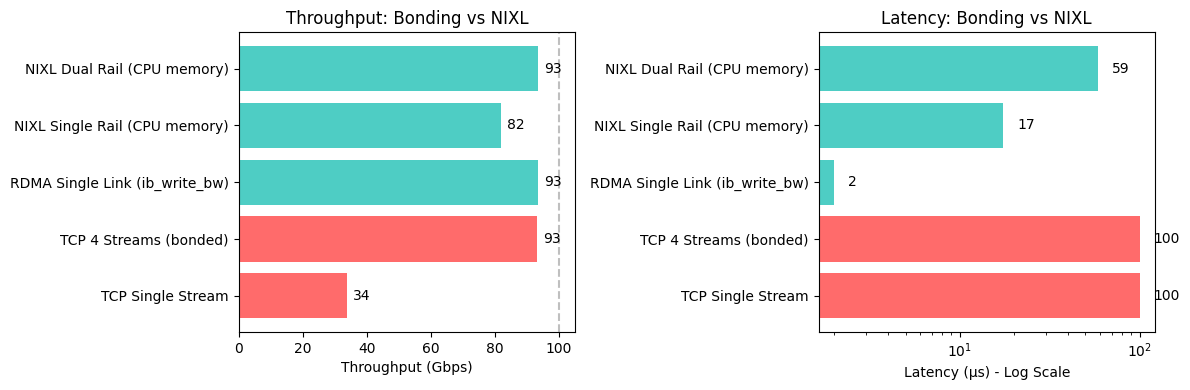


Chart saved to bonding_vs_nixl_comparison.png


In [18]:
# Visualization
try:
    import matplotlib.pyplot as plt
    import math

    tests = list(comparison_data.keys())
    throughputs = [d["gbps"] for d in comparison_data.values()]
    latencies = [d["latency_us"] for d in comparison_data.values()]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Throughput comparison
    colors = ['#ff6b6b' if 'TCP' in t else '#4ecdc4' for t in tests]
    bars1 = ax1.barh(tests, throughputs, color=colors)
    ax1.set_xlabel('Throughput (Gbps)')
    ax1.set_title('Throughput: Bonding vs NIXL')
    ax1.axvline(x=100, color='gray', linestyle='--', alpha=0.5)

    for bar, val in zip(bars1, throughputs):
        ax1.text(val + 2, bar.get_y() + bar.get_height()/2, f'{val:.0f}',
                va='center', fontsize=10)

    # Latency comparison (log scale)
    if any(isinstance(v, (int, float)) and math.isnan(v) for v in latencies):
        ax2.text(0.5, 0.5, 'Latency chart skipped\n(missing values)',
                 transform=ax2.transAxes, ha='center', va='center', fontsize=10)
        ax2.set_axis_off()
    else:
        bars2 = ax2.barh(tests, latencies, color=colors)
        ax2.set_xlabel('Latency (μs) - Log Scale')
        ax2.set_xscale('log')
        ax2.set_title('Latency: Bonding vs NIXL')

        for bar, val in zip(bars2, latencies):
            ax2.text(val * 1.2, bar.get_y() + bar.get_height()/2, f'{val:.0f}',
                    va='center', fontsize=10)

    plt.tight_layout()
    plt.savefig('bonding_vs_nixl_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("\nChart saved to bonding_vs_nixl_comparison.png")

except ImportError:
    print("matplotlib not installed. Install with: pip install matplotlib")

---

## Part 6: Key Findings

### Why Bonding Underperforms

```
TCP/IP Path (Bonding):
  Application → Socket API → Kernel TCP/IP Stack → Driver → NIC
  
RDMA Path (NIXL):
  Application → Verbs API → NIC (direct memory access)
```

The kernel TCP/IP stack introduces:
- **CPU overhead**: Context switches, buffer copies, interrupt handling
- **Latency**: 50-200 μs vs 1-2 μs for RDMA
- **Throughput ceiling**: ~35 Gbps per flow regardless of link speed

### When to Use Each Approach

| Workload | Recommended |
|----------|-------------|
| KV-cache transfer | NIXL |
| Tensor shard movement | NIXL |
| Disaggregated inference | NIXL |
| Collective operations | NCCL (see [first tutorial](01_InfiniBand_Tutorial.ipynb)) |
| SSH/management | Bonding |
| NFS storage | Bonding |

### Coexistence

Bonding and NIXL can coexist:
- Bond for IP traffic (uses kernel stack)
- NIXL for RDMA (bypasses kernel entirely)

RDMA verbs access `mlx5_0`/`mlx5_1` directly; traffic does not traverse `bond0`.

---

## Part 7: Cleanup

Remove the bond interface if no longer needed.

In [ ]:
# Commands to remove bond (run manually if needed)
print("To remove the bond interface:")
print("""
sudo ip link set bond0 down
sudo ip link set enp1s0f0np0 nomaster
sudo ip link set enp1s0f1np1 nomaster
sudo ip link delete bond0

# Restore individual interface IPs if needed
sudo ip addr add 192.168.100.10/24 dev enp1s0f0np0
sudo ip addr add 192.168.200.10/24 dev enp1s0f1np1
""")

---

## References

- [RoCE Link Aggregation Tutorial (Markdown)](02_Multi_Rail_Tutorial.md)
- [NCCL and RDMA Benchmarks (First Tutorial)](01_InfiniBand_Tutorial.ipynb)
- [NIXL GitHub Repository](https://github.com/ai-dynamo/nixl)
- [Linux Kernel Bonding Documentation](https://www.kernel.org/doc/Documentation/networking/bonding.txt)